# SCP Dataset Exploration and Visualizations
## Overview
This file was created to explore various aspects of the SCP dataset in order to select interesting visualizations for the SCP Status dashboard.
## Setup

In [68]:
#!pip install pandas
#!pip install matplotlib
#!pip install dash
#!pip install plotly

In [98]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import re
import plotly.graph_objects as go
import plotly.express as px

In [100]:
df = pd.read_csv("scp6999augmented.csv")

## Investigating negative mentions

I was originally under the impression that the `text` value provided for every SCP article contained, at the end, the code of the previous and next SCPs because the data scraped included the links to the previous and next SCP code present at the bottom of the article. I thus designed the following function to create the `mentions` column:

```
def count_mentions(code): #counts mentions of a SCP in the text column of every row except its own
    mentions = 0
    temp_df = df[df['code'] != code] # remove the SCP's own article
    for scp_text in temp_df['text']:
        mentions = mentions + scp_text.count(code)
    if code in ["SCP-001", "SCP-6999"]:
        mentions = mentions -1
    else:
        mentions = mentions - 2 # these must be substracted because at the end of each SCP article is a link to the previous and next ones
    return mentions
```

However, I must have been wrong because some SCPs currently have -1 or -2 as their `mentions` value.

In [350]:
negative_mentions_df = df[df["mentions"]<0]

In [354]:
negative_mentions_df["code"]

3406    SCP-3407
3643    SCP-3644
3645    SCP-3646
3773    SCP-3774
3775    SCP-3776
          ...   
6597    SCP-6979
6599    SCP-6981
6604    SCP-6986
6605    SCP-6987
6606    SCP-6988
Name: code, Length: 372, dtype: object

The smallest SCP code i got is 3407. Perhaps there was a change in the webpages from then on (or a bit before) that made it so the links included in them were included not included in the scraped `text` value?

In [375]:
str(df.loc[df['code'] == 'SCP-3406']["text"])[-200:]

'ctivities, and could potentially result in an MA-Class Mass Animation Scenario if used extensively. SCP-3406 is considered uncontained. \\n « SCP-3405 | SCP-3406 | SCP-3407 »"\nName: text, dtype: object'

In [377]:
str(df.loc[df['code'] == 'SCP-3407']["text"])[-200:]

'm burns out. Projection continues for another 30 seconds before becoming inoperable. \\n « SCP-3406 | SCP-3407 | SCP-3408 » \\n Click here to check out HotColes\'s Author Page."\nName: text, dtype: object'

In [379]:
str(df.loc[df['code'] == 'SCP-3408']["text"])[-1000:]

' primary function. \\n Please. \\n Come to Site-3408. \\n Please. \\n « Site-3407 | Site-3408 | Site-3409 » \\n Cite this page as: \\n "Site-3408" by Jim North, from the SCP Wiki. Source: https://scp-wiki.wikidot.com/scp-3408. Licensed under CC-BY-SA. \\n For more information, see Licensing Guide.\\nLicensing Disclosures \\n Filename: site3408_01.jpg\\nName: Dreams resort & Spa, Los Cabos Mexico\\nAuthor: Ian D. Keating\\nLicense: CC BY 2.0\\nSource Link: pxhere \\n Filename: site3408_02.jpg\\nName: N/A\\nAuthor: N/A\\nLicense: CC0\\nSource Link: pxhere \\n Filename: site3408_03.jpg\\nName: N/A\\nAuthor: N/A\\nLicense: CC0\\nSource Link: pxhere \\n Filename: site3408_04.jpg\\nName: N/A\\nAuthor: N/A\\nLicense: CC0\\nSource Link: pxhere \\n Filename: site3408_05.jpg\\nName: N/A\\nAuthor: N/A\\nLicense: CC0\\nSource Link: pxhere \\n Filename: site3408_06.jpg\\nName: N/A\\nAuthor: N/A\\nLicense: CC0\\nSource Link: pxhere \\n For more information about on-wiki content, visit the Licensing

Alright so I see what happened here: the link was labeled "Site-3407" instead of "SCP-3407" so it was not counted. This should however only affect the mentions count for SCP-3407 and SCP-3409, of course, so I’ll have to investigate further.

In [399]:
str(df.loc[df['code'] == 'SCP-3643']["text"])[-200:]

'ON OUR NEW DAVID FINCHER DIRECTED FOUNDATION MURDER MYSTERY GAME \\n THANKS AND BUY OUR PRODUCTS AND DONATE TO US \\n KEPHART CORPORATION \\n « SCP-3642 | SCP-3643 | SCP-3644 »"\nName: text, dtype: object'

In [401]:
str(df.loc[df['code'] == 'SCP-3644']["text"])[-500:]

'rance could be ascertained. The following physical characteristics were described by Dr. Salem-Orden in her initial report regarding the entity: \\n « SCP-3643 | SCP-3644 | SCP-3645 » \\n Cite this page as: \\n "SCP-3644" by Rhineriver, from the SCP Wiki. Source: https://scp-wiki.wikidot.com/scp-3644. Licensed under CC-BY-SA. \\n For more information, see Licensing Guide.\\nLicensing Disclosures \\n For more information about on-wiki content, visit the Licensing Master List."\nName: text, dtype: object'

In [404]:
str(df.loc[df['code'] == 'SCP-3645']["text"])[-500:]

'have been redacted for containing mild cognitohazardous elements.] \\n SCP-3645: Hurry! \\n [The sound of objects falling and hitting the floor is heard. Agent Belgrave is unresponsive.] \\n (Silence for several seconds) \\n SCP-3645: Please be quick! \\n [Foundation medical agents arrive on the scene. They are successful in dismantling the door to the Birchby residence and remove Agent Belgrave from the residence.] \\n (Silence for several seconds) \\n SCP-3645: Uncle Tony…?"\nName: text, dtype: object'

So the article for SCP-3645 could be the first one to be formatted differently, without the links being part of the `text` value?

I looked into it and it IS formatted differently, but then SCP-3646 goes back to the original SCP formatting. So I’m thinking I should just use a REGEX to replace all the bottom of page link labels by an empty string, THEN calculate the number of mentions.

In [417]:
str(df.loc[df['code'] == 'SCP-001']["text"])[-1000:]

' Noir Box - Tindalos Trinity \\n CODE NAME: Tanhony II - The Black Moon \\n CODE NAME: The Conspiracy \\n CODE NAME: Arbelict - You Are The Anomaly, Tumor Of The Worlds \\n CODE NAME: McDoctorate - The Placeholder \\n CODE NAME: ROUNDERHOUSE - MEMENTO MORI \\n CODE NAME: Dr. Eates - A Test of Character \\n CODE NAME: Pickman/Blank - The Frontispiece \\n CODE NAME: ROUNDERHOUSE\'s Gold Proposal - AMONI-RAM \\n CODE NAME: Ralliston - The Queen\'s Gambit \\n CODE NAME: KingPogan - The Insurgency \\n Cite this page as: \\n "SCP-001" by Staff, from the SCP Wiki. Source: https://scp-wiki.wikidot.com/scp-001. Licensed under CC-BY-SA. \\n For more information, see Licensing Guide.\\nLicensing Disclosures \\n Filename: fractal-mka.jpeg\\nName: Feather fractal\\nAuthor: Kevin Dooley\\nLicense: CC BY 2.0\\nSource Link: Flickr \\n Filename: sdl-ihp-001.gif\\nAuthor: Lt Flops\\nLicense: CC BY-SA 3.0\\nSource Link: N/A \\n For more information about on-wiki content, visit the Licensing Master List.

OK so SCP-001 doesn't have the links AT ALL so I don’t have to worry about a series of two links instead of three. I can just use `\w+-\d+ [|] \w+-\d+ [|] \w+-\d+` as the REGEX.

In [428]:
links_pattern = r"« \w+-\d+ [|] \w+-\d+ [|] \w+-\d+ »"
test_string = str(df.loc[df['code'] == 'SCP-3644']["text"])
test_string = re.sub(links_pattern, "", test_string)
test_string[-500:]

'arding the entity\'s physical appearance could be ascertained. The following physical characteristics were described by Dr. Salem-Orden in her initial report regarding the entity: \\n  \\n Cite this page as: \\n "SCP-3644" by Rhineriver, from the SCP Wiki. Source: https://scp-wiki.wikidot.com/scp-3644. Licensed under CC-BY-SA. \\n For more information, see Licensing Guide.\\nLicensing Disclosures \\n For more information about on-wiki content, visit the Licensing Master List."\nName: text, dtype: object'

This appeared to work, so I rewrote the function:

```
def count_mentions(code): #counts mentions of a SCP in the text column of every row except its own
    links_pattern = r"« \w+-\d+ [|] \w+-\d+ [|] \w+-\d+ »"
    mentions = 0
    temp_df = df[df['code'] != code] # remove the SCP's own article
    for scp_text in temp_df['text']:
        scp_text = re.sub(links_pattern, "", scp_text)
        mentions = mentions + scp_text.count(code)
    return mentions
```

So I ran `datawrangling.py` again with the new version of the function. It should no longer generate negative `mentions` values.

In [435]:
df = pd.read_csv("scp6999augmented.csv")
negative_mentions_df = df[df["mentions"]<0]
negative_mentions_df["code"]

Series([], Name: code, dtype: object)

I get no results! Perfect!

## Visualizations
### Object classes

In [438]:
primary_classes=["Safe", "Euclid", "Keter"]
primary_classes_df = df[df["class"].isin(primary_classes)]

In [440]:
class_counts = primary_classes_df.groupby(["class", "series"]).count().reset_index()

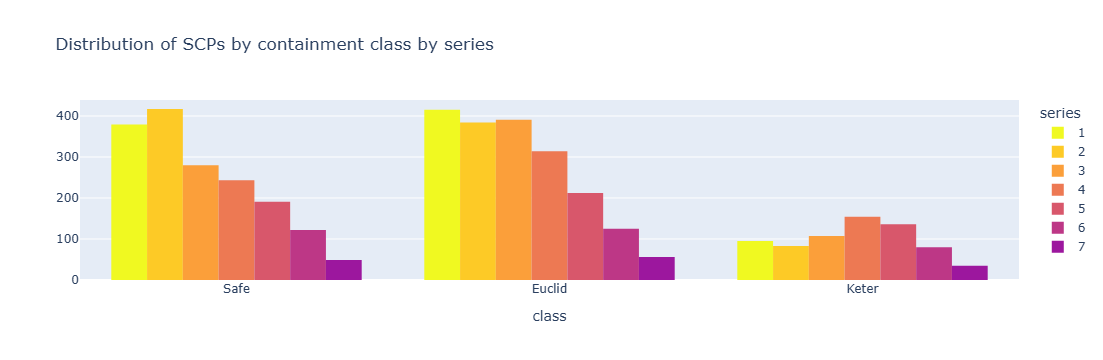

In [442]:
fig = px.histogram(class_counts, x="class", y="code", color="series", color_discrete_sequence=px.colors.sequential.Plasma_r, barmode="group",
                  title="Distribution of SCPs by containment class by series")
fig.update_xaxes(categoryorder="array", categoryarray=primary_classes)
fig.update_layout(yaxis_title="")
fig.update_traces(hovertemplate='Total SCPs: %{y}<extra></extra>')
fig.show()

### SCP mentions in other articles

In [445]:
top10 = df.sort_values(by='mentions', ascending=False).head(10)

In [447]:
top10[["code", "mentions"]]

,code,mentions
616,SCP-617,980
457,SCP-458,753
605,SCP-606,724
299,SCP-300,703
478,SCP-479,675
501,SCP-502,669
499,SCP-500,666
309,SCP-310,661
444,SCP-445,660
300,SCP-301,652


### █ per article

In [450]:
def contains_count(string, elements):
    count = 0
    for element in elements:
        count += string.count(element)
    return count

In [452]:
black_df = df
black_df["black rectangles"] = black_df.apply(lambda row: contains_count(row["text"], ["█"]), axis=1)

In [454]:
topclasses = pd.DataFrame(df["class"].value_counts()).head(3).reset_index()
tclist = topclasses["class"].tolist()

In [456]:
tc_scps = black_df["class"].isin(tclist)
black_df = black_df[tc_scps]

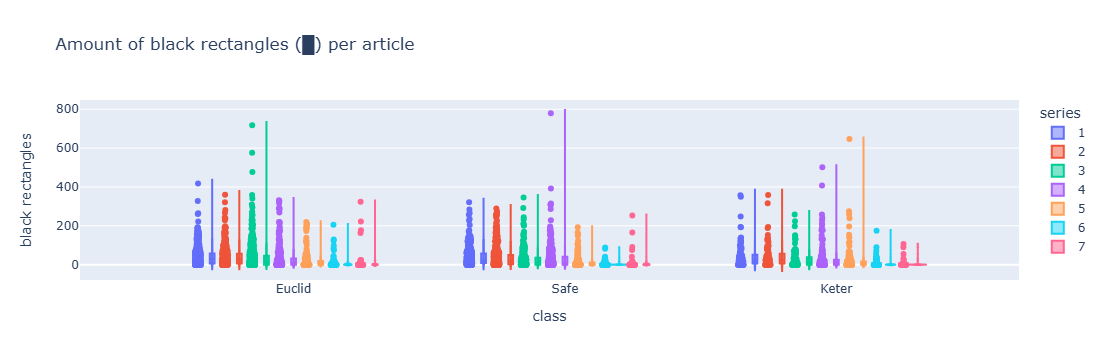

In [458]:
figure=px.violin(
            black_df,
            y="black rectangles",
            x="class",
            color="series",
            box=True,
            points="all",
            hover_data={"code":True, "title":True, "class": False, "series": False},
            title = "Amount of black rectangles (█) per article"
        )
figure.show()

### Average number of characters and popularity by class by series

In [460]:
df["length"]=df.apply(lambda row: len(row["text"]), axis=1)

In [461]:
df.describe()

,Unnamed: 0,rating,series,mentions,black rectangles,length
count,6618.000000,6611.000000,6618.000000,6618.000000,6618.000000,6618.000000
mean,3321.994107,171.366359,3.827894,30.398761,29.087186,9823.402841
std,1933.384973,257.473717,1.920317,99.312634,84.073691,9666.486295
min,0.000000,-36.000000,1.000000,0.000000,0.000000,36.000000
25%,1654.250000,56.000000,2.000000,0.000000,0.000000,4461.500000
50%,3308.500000,107.000000,4.000000,0.000000,4.000000,7085.000000
75%,4962.750000,200.000000,5.000000,1.000000,32.000000,11739.500000
max,6998.000000,7663.000000,7.000000,980.000000,4204.000000,211898.000000


In [462]:
ratings_df = df.dropna(subset=["rating"])
ratings_df = ratings_df[ratings_df["rating"] > 0]

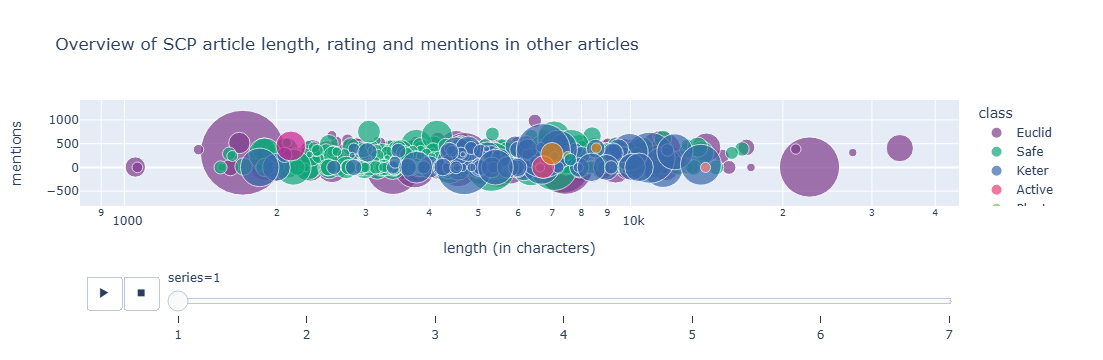

In [467]:
figure=px.scatter(
    ratings_df.dropna(subset=["rating"]),
    x="length",
    y="mentions",
    size="rating",
    color="class",
    color_discrete_sequence=px.colors.qualitative.Bold,
    hover_name="code",
    animation_frame="series",
    hover_data = {"series":False},
    log_x=True,
    size_max=60,
    title="Overview of SCP article length, rating and mentions in other articles",
)
figure.update_layout(xaxis_title="length (in characters)")
figure.show()

In [468]:
top5classes = pd.DataFrame(ratings_df["class"].value_counts()).head(5).reset_index()["class"].tolist()
top5classes

['Euclid', 'Safe', 'Keter', 'Thaumiel', 'Neutralized']

In [469]:
is_top5class = ratings_df["class"].isin(top5classes)

In [472]:
ratings_df.loc[-is_top5class, "class"] = "Other"

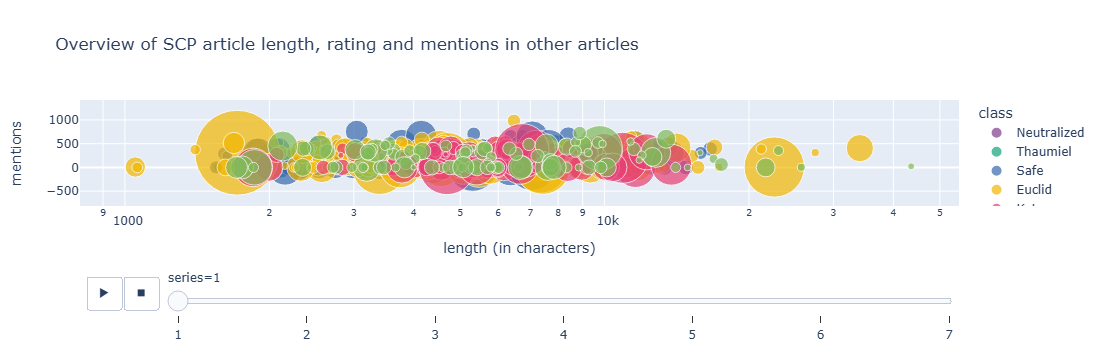

In [473]:
figure=px.scatter(
    ratings_df.dropna(subset=["rating"]),
    x="length",
    y="mentions",
    size="rating",
    color="class",
    color_discrete_sequence=px.colors.qualitative.Bold,
    hover_name="code",
    animation_frame="series",
    hover_data = {"series":False},
    log_x=True,
    size_max=60,
    title="Overview of SCP article length, rating and mentions in other articles",
    category_orders={"class": ["Neutralized", "Thaumiel", "Safe", "Euclid", "Keter", "Other"]}
)
figure.update_layout(xaxis_title="length (in characters)")
figure.show()

### Top 5

In [482]:
df.describe()

,Unnamed: 0,rating,series,mentions,black rectangles,length
count,6618.000000,6611.000000,6618.000000,6618.000000,6618.000000,6618.000000
mean,3321.994107,171.366359,3.827894,30.398761,29.087186,9823.402841
std,1933.384973,257.473717,1.920317,99.312634,84.073691,9666.486295
min,0.000000,-36.000000,1.000000,0.000000,0.000000,36.000000
25%,1654.250000,56.000000,2.000000,0.000000,0.000000,4461.500000
50%,3308.500000,107.000000,4.000000,0.000000,4.000000,7085.000000
75%,4962.750000,200.000000,5.000000,1.000000,32.000000,11739.500000
max,6998.000000,7663.000000,7.000000,980.000000,4204.000000,211898.000000


In [484]:
df.columns

Index(['Unnamed: 0', 'code', 'title', 'text', 'image captions', 'rating',
       'state', 'tags', 'link', 'class type', 'class', 'series', 'mentions',
       'black rectangles', 'length'],
      dtype='object')

In [540]:
top5_df = pd.DataFrame(columns=['category', 'title', 'amount', 'rank'])

In [542]:
top5_df

,category,title,amount,rank


In [550]:
def get_code_plus_title(code, title):
    return str(code) + ": " + str(title)

top_rated_df = df.sort_values(by="rating", ascending=False).head()[["code", "title", "rating"]]
top_rated_df["title"] = top_rated_df.apply(lambda row: get_code_plus_title(row["code"], row["title"]), axis=1)
top_rated_df["rank"] = range(1, len(top_rated_df) + 1)
top_rated_df.pop("code")
top_rated_df.rename(columns={"rating": "amount"}, inplace=True)
top_rated_df["category"] = "rating (points)"

In [552]:
top_rated_df

,title,amount,rank,category
172,"SCP-173: ""The Original""",7663.0,1,rating (points)
2520,"SCP-2521: ""●●|●●●●●|●●|●""",5027.0,2,rating (points)
48,"SCP-049: ""Plague Doctor""",3860.0,3,rating (points)
54,"SCP-055: ""[unknown]""",3364.0,4,rating (points)
95,"SCP-096: ""The ""Shy Guy""""",3229.0,5,rating (points)


In [554]:
top5_df = pd.concat([top5_df, top_rated_df], ignore_index=True)

C:\Users\agaco\AppData\Local\Temp\ipykernel_27760\2165512665.py:1: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



In [556]:
top5_df

,category,title,amount,rank
0,rating (points),"SCP-173: ""The Original""",7663.0,1
1,rating (points),"SCP-2521: ""●●|●●●●●|●●|●""",5027.0,2
2,rating (points),"SCP-049: ""Plague Doctor""",3860.0,3
3,rating (points),"SCP-055: ""[unknown]""",3364.0,4
4,rating (points),"SCP-096: ""The ""Shy Guy""""",3229.0,5


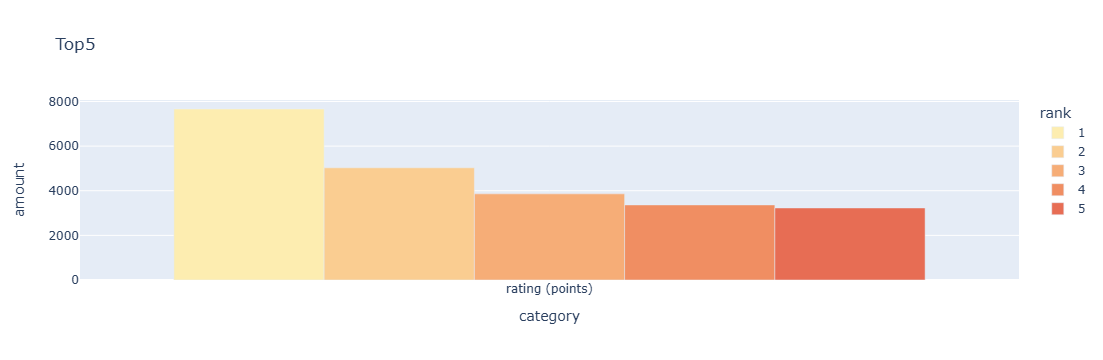

In [568]:
fig = px.bar(top5_df, x="category", y="amount", color="rank", color_discrete_sequence=px.colors.sequential.matter, barmode="group",
                  title="Top5", hover_name="title")
fig.show()

C:\Users\agaco\AppData\Local\Temp\ipykernel_27760\1334738845.py:19: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



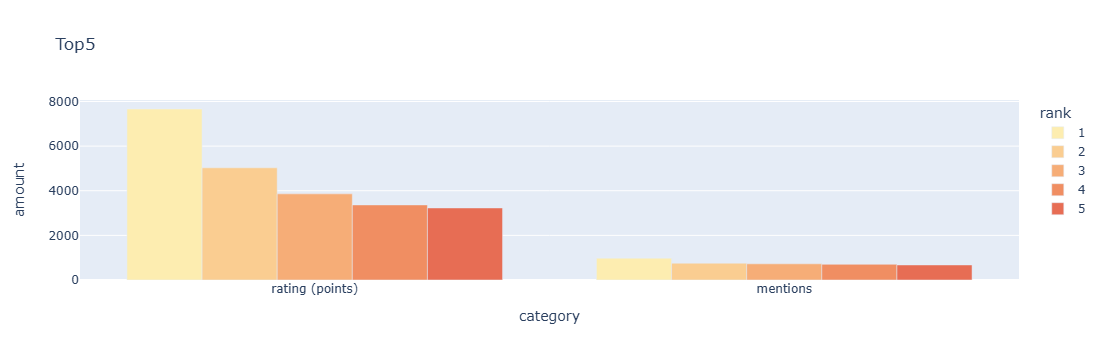

In [572]:
def get_code_plus_title(code, title):
    return str(code) + ": " + str(title[1:-1])

top_rated_df = df.sort_values(by="rating", ascending=False).head()[["code", "title", "rating"]]
top_rated_df["title"] = top_rated_df.apply(lambda row: get_code_plus_title(row["code"], row["title"]), axis=1)
top_rated_df["rank"] = range(1, len(top_rated_df) + 1)
top_rated_df.pop("code")
top_rated_df.rename(columns={"rating": "amount"}, inplace=True)
top_rated_df["category"] = "rating (points)"

most_refs_df = df.sort_values(by="mentions", ascending=False).head()[["code", "title", "mentions"]]
most_refs_df["title"] = most_refs_df.apply(lambda row: get_code_plus_title(row["code"], row["title"]), axis=1)
most_refs_df["rank"] = range(1, len(top_rated_df) + 1)
most_refs_df.pop("code")
most_refs_df.rename(columns={"mentions": "amount"}, inplace=True)
most_refs_df["category"] = "mentions"

top5_df = pd.DataFrame(columns=['category', 'title', 'amount', 'rank'])
top5_df = pd.concat([top5_df, top_rated_df, most_refs_df], ignore_index=True)

fig = px.bar(top5_df, x="category", y="amount", color="rank", color_discrete_sequence=px.colors.sequential.matter, barmode="group",
                  title="Top5", hover_name="title")
fig.show()